# Covid-19: From model prediction to model predictive control

## Long term predictions for FAGG

*Authored by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime
import scipy
import json
import random

Load the covid 19 custom development code

In [4]:
from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.models.utils import draw_sample_COVID19_SEIRD
from covid19model.data import google, sciensano, model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

In [5]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data, policy and model initialization

### Load contact data

In [6]:
# Load the interaction matrices (size: 9x9)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')
# Define the number of age categories
levels = initN.size

### Load publically available data from Sciensano

In [7]:
# Scrape the publically available data from the Scientific institute of Public Health (Sciensano)
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.tail()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-10-01,771,156,87,67,867,15,0.0,2.0,3.0,5,5.0
2020-10-02,789,163,66,50,883,11,0.0,0.0,2.0,6,3.0
2020-10-03,819,185,73,74,882,13,0.0,0.0,4.0,4,5.0
2020-10-04,866,186,86,34,934,14,0.0,0.0,1.0,5,8.0
2020-10-05,937,195,87,33,988,3,0.0,1.0,0.0,2,0.0


### Load posterior parameter distributions of calibrated parameters

In [11]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/deterministic_2020-10-22.json', 'r') as fp:
    samples_dict = json.load(fp)

### Define social policy

In [9]:
def lockdown_release(t,param,policy_time,policy1,policy2,policy3,policy4,policy5,policy6,policy7,policy8,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return policy1 + (prevention*policy2-policy1)/l*(t-policy_time-tau)
    elif policy_time + tau + l < t <= policy_time + 50: 
        return prevention*policy2
    elif policy_time + 50 < t <= policy_time + 52:
        return prevention*policy3
    elif policy_time + 52 < t <= policy_time + 57:
        return prevention*policy4
    elif policy_time + 57 < t <= policy_time + 64:
        return prevention*policy5
    elif policy_time + 64 < t <= policy_time + 81:
        return prevention*policy6
    elif policy_time + 81 < t <= policy_time + 108:
        return prevention*policy7
    elif policy_time + 108 < t <= policy_time + 170:
        return prevention*policy8

### Initialize model

In [12]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy3': 1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure,
              'policy4': 1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure,
              'policy5': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure,
              'policy6': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.15)*Nc_others + (1-0.85)*Nc_schools + (1-0.50)*Nc_leisure,
              'policy7': 1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.10)*Nc_others + (1-0.35)*Nc_schools + (1-0.30)*Nc_leisure,
              'policy8': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure,
               'policy_time': samples_dict['lag_time'],
              'l': 1,
              'tau': 5,
              'prevention': 0.5})

# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_release})

## Run model untill September 1st

In [14]:
out = model.sim(170,N=200,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

In [15]:
start_date = datetime.datetime.strptime('15-03-2020', '%d-%m-%Y') - datetime.timedelta(days=samples_dict['lag_time'])
dates = pd.date_range(start_date, periods=len(out["time"].values)).date

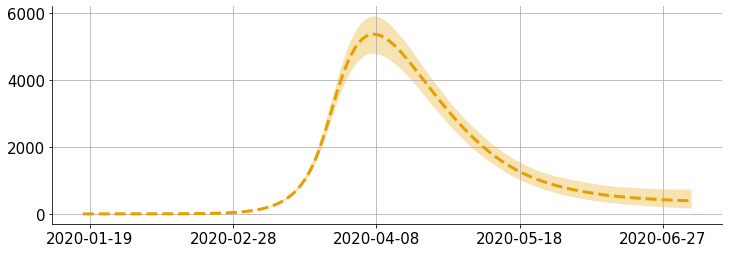

In [19]:
fig,ax =plt.subplots(figsize=(12,4))
ax.fill_between(dates, out["H_tot"].quantile(1-0.90,dim="draws").sum(dim="Nc"), out["H_tot"].quantile(0.90,dim="draws").sum(dim="Nc"),alpha=0.30)
ax.plot(dates,out["H_tot"].mean(dim="draws").sum(dim="Nc"),'--')
# limit the number of ticks on the axis
from covid19model.visualization.output import _apply_tick_locator
ax = _apply_tick_locator(ax)

## Re-initialize model with September 1st as initial condition

In [20]:
def long_term_policy(t,param,policy1,policy2,policy3,policy4,policy5,policy6,policy7,l,tau,prevention):
    if 0 < t <=  62:
        return prevention*policy1
    elif 62 < t <= 69:
        return prevention*policy2
    elif 69 < t <= 111:
        return prevention*policy3
    elif 111 < t <= 121:
        return prevention*policy4
    elif 121 < t <= 167:
        return prevention*policy5
    elif 167 < t <= 173:
        return prevention*policy6 
    else:
        return prevention*policy7

In [21]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'policy1': 1.0*Nc_home + (1-0.00)*Nc_work + (1-0.00)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_schools + (1-0.00)*Nc_leisure,
              'policy2': 1.0*Nc_home + (1-0.00)*Nc_work + (1-0.00)*Nc_transport + (1-0.00)*Nc_others + (1-1.00)*Nc_schools + (1-0.00)*Nc_leisure,
              'policy3': 1.0*Nc_home + (1-0.00)*Nc_work + (1-0.00)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_schools + (1-0.00)*Nc_leisure,
              'policy4': 1.0*Nc_home + (1-0.00)*Nc_work + (1-0.00)*Nc_transport + (1-0.00)*Nc_others + (1-1.00)*Nc_schools + (1-0.00)*Nc_leisure,
              'policy5': 1.0*Nc_home + (1-0.00)*Nc_work + (1-0.00)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_schools + (1-0.00)*Nc_leisure,
              'policy6': 1.0*Nc_home + (1-0.00)*Nc_work + (1-0.00)*Nc_transport + (1-0.00)*Nc_others + (1-1.00)*Nc_schools + (1-0.00)*Nc_leisure,
              'policy7': 1.0*Nc_home + (1-0.00)*Nc_work + (1-0.00)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_schools + (1-0.00)*Nc_leisure,
              'l' : 0.5,
              'tau': 0.5,
              'prevention' : 0.5})

In [24]:
initial_states = {'S': out['S'].mean(dim="draws").isel(time=170),
                  'E': out['E'].mean(dim="draws").isel(time=170),
                  'I': out['I'].mean(dim="draws").isel(time=170),
                  'A': out['A'].mean(dim="draws").isel(time=170),
                  'M': out['M'].mean(dim="draws").isel(time=170),
                  'ER': out['ER'].mean(dim="draws").isel(time=170),
                  'C': out['C'].mean(dim="draws").isel(time=170),
                  'C_icurec': out['C_icurec'].mean(dim="draws").isel(time=170),
                  'ICU': out['ICU'].mean(dim="draws").isel(time=170),
                  'R': out['R'].mean(dim="draws").isel(time=170),
                  'D': out['D'].mean(dim="draws").isel(time=170),
                  'H_in': out['H_in'].mean(dim="draws").isel(time=170),
                  'H_out': out['H_out'].mean(dim="draws").isel(time=170),
                  'H_tot': out['H_tot'].mean(dim="draws").isel(time=170)}

# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': long_term_policy})

In [25]:
model.parameters['s']=model.parameters['s']*1.10

## Simulations

### S1: all contacts

In [30]:
MC_out_1 = model.sim(300,N=1000,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

In [31]:
start_date = datetime.datetime.strptime('01-09-2020', '%d-%m-%Y')
dates = pd.date_range(start_date, periods=len(MC_out_1["time"].values)).date

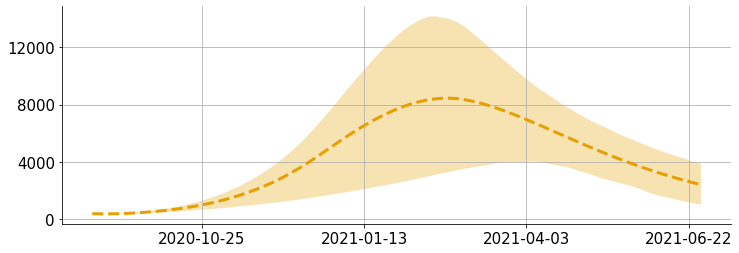

In [32]:
fig,ax =plt.subplots(figsize=(12,4))
ax.fill_between(dates, MC_out_1["H_tot"].quantile(1-0.80,dim="draws").sum(dim="Nc"), MC_out_1["H_tot"].quantile(0.80,dim="draws").sum(dim="Nc"),alpha=0.30)
ax.plot(dates,MC_out_1["H_tot"].mean(dim="draws").sum(dim="Nc"),'--')
# limit the number of ticks on the axis
from covid19model.visualization.output import _apply_tick_locator
ax = _apply_tick_locator(ax)

In [33]:
# New hospitalisations
S1_incidences_mean = MC_out_1["H_in"].sum(dim="Nc").mean(dim="draws").values
S1_incidences_LL = MC_out_1["H_in"].sum(dim="Nc").quantile(0.2,dim="draws").values
S1_incidences_UL = MC_out_1["H_in"].sum(dim="Nc").quantile(0.8,dim="draws").values
# Hospital totals
S1_load_mean = MC_out_1["H_tot"].sum(dim="Nc").mean(dim="draws").values
S1_load_LL = MC_out_1["H_tot"].sum(dim="Nc").quantile(0.2,dim="draws").values
S1_load_UL = MC_out_1["H_tot"].sum(dim="Nc").quantile(0.8,dim="draws").values

### S2: -10% contacts

In [34]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'policy1': 1.0*Nc_home + (1-0.10)*Nc_work + (1-0.10)*Nc_transport + (1-0.10)*Nc_others + (1-0.00)*Nc_schools + (1-0.10)*Nc_leisure,
              'policy2': 1.0*Nc_home + (1-0.10)*Nc_work + (1-0.10)*Nc_transport + (1-0.10)*Nc_others + (1-1.00)*Nc_schools + (1-0.10)*Nc_leisure,
              'policy3': 1.0*Nc_home + (1-0.10)*Nc_work + (1-0.10)*Nc_transport + (1-0.10)*Nc_others + (1-0.00)*Nc_schools + (1-0.10)*Nc_leisure,
              'policy4': 1.0*Nc_home + (1-0.10)*Nc_work + (1-0.10)*Nc_transport + (1-0.10)*Nc_others + (1-1.00)*Nc_schools + (1-0.10)*Nc_leisure,
              'policy5': 1.0*Nc_home + (1-0.10)*Nc_work + (1-0.10)*Nc_transport + (1-0.10)*Nc_others + (1-0.00)*Nc_schools + (1-0.10)*Nc_leisure,
              'policy6': 1.0*Nc_home + (1-0.10)*Nc_work + (1-0.10)*Nc_transport + (1-0.10)*Nc_others + (1-1.00)*Nc_schools + (1-0.10)*Nc_leisure,
              'policy7': 1.0*Nc_home + (1-0.10)*Nc_work + (1-0.10)*Nc_transport + (1-0.10)*Nc_others + (1-0.00)*Nc_schools + (1-0.10)*Nc_leisure,
              'l' : 1,
              'tau' : 5,
              'prevention': 0.5})

# Re-initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': long_term_policy})

In [35]:
model.parameters['s']=model.parameters['s']*1.10

In [36]:
MC_out_2 = model.sim(300,N=1000,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

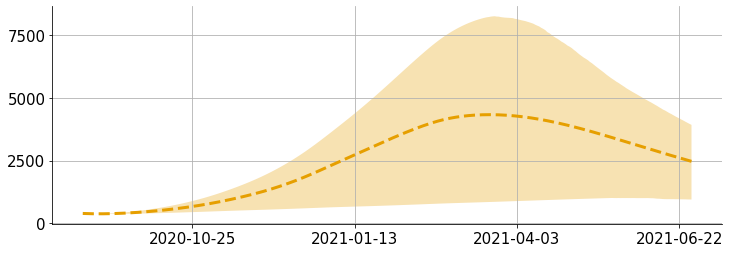

In [37]:
fig,ax =plt.subplots(figsize=(12,4))
ax.fill_between(dates, MC_out_2["H_tot"].quantile(1-0.80,dim="draws").sum(dim="Nc"), MC_out_2["H_tot"].quantile(0.80,dim="draws").sum(dim="Nc"),alpha=0.30)
ax.plot(dates,MC_out_2["H_tot"].mean(dim="draws").sum(dim="Nc"),'--')
# limit the number of ticks on the axis
from covid19model.visualization.output import _apply_tick_locator
ax = _apply_tick_locator(ax)

In [38]:
# New hospitalisations
S2_incidences_mean = MC_out_2["H_in"].sum(dim="Nc").mean(dim="draws").values
S2_incidences_LL = MC_out_2["H_in"].sum(dim="Nc").quantile(0.2,dim="draws").values
S2_incidences_UL = MC_out_2["H_in"].sum(dim="Nc").quantile(0.8,dim="draws").values
# Hospital totals
S2_load_mean = MC_out_2["H_tot"].sum(dim="Nc").mean(dim="draws").values
S2_load_LL = MC_out_2["H_tot"].sum(dim="Nc").quantile(0.2,dim="draws").values
S2_load_UL = MC_out_2["H_tot"].sum(dim="Nc").quantile(0.8,dim="draws").values

### S3: -20% contacts

In [25]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'policy1': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.20)*Nc_transport + (1-0.20)*Nc_others + (1-0.00)*Nc_schools + (1-0.20)*Nc_leisure,
              'policy2': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.20)*Nc_transport + (1-0.20)*Nc_others + (1-1.00)*Nc_schools + (1-0.20)*Nc_leisure,
              'policy3': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.20)*Nc_transport + (1-0.20)*Nc_others + (1-0.00)*Nc_schools + (1-0.20)*Nc_leisure,
              'policy4': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.20)*Nc_transport + (1-0.20)*Nc_others + (1-1.00)*Nc_schools + (1-0.20)*Nc_leisure,
              'policy5': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.20)*Nc_transport + (1-0.20)*Nc_others + (1-0.00)*Nc_schools + (1-0.20)*Nc_leisure,
              'policy6': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.20)*Nc_transport + (1-0.20)*Nc_others + (1-1.00)*Nc_schools + (1-0.20)*Nc_leisure,
              'policy7': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.20)*Nc_transport + (1-0.20)*Nc_others + (1-0.00)*Nc_schools + (1-0.20)*Nc_leisure,
              'l': 1,
              'tau': 5,
              'prevention': 0.5})

In [26]:
model.parameters['s']=model.parameters['s']*1.10

In [27]:
# Re-initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': long_term_policy})

In [28]:
MC_out_3 = MC_sim(model,1000,300,draw_sample_COVID19_SEIRD,samples_dict)

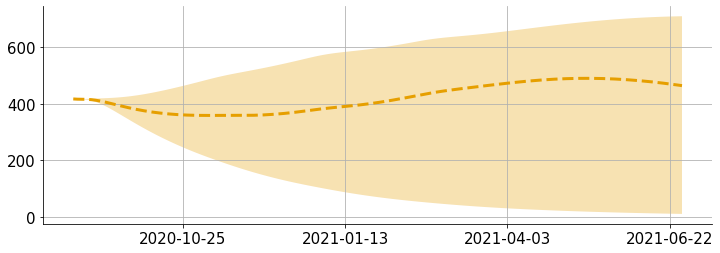

In [29]:
fig,ax =plt.subplots(figsize=(12,4))
ax.fill_between(dates, MC_out_3["H_tot"].quantile(1-0.80,dim="MC").sum(dim="Nc"), MC_out_3["H_tot"].quantile(0.80,dim="MC").sum(dim="Nc"),alpha=0.30)
ax.plot(dates,MC_out_3["H_tot"].mean(dim="MC").sum(dim="Nc"),'--')
# limit the number of ticks on the axis
from covid19model.visualization.output import _apply_tick_locator
ax = _apply_tick_locator(ax)

In [30]:
# New hospitalisations
S3_incidences_mean = MC_out_3["H_in"].sum(dim="Nc").mean(dim="MC").values
S3_incidences_LL = MC_out_3["H_in"].sum(dim="Nc").quantile(0.2,dim="MC").values
S3_incidences_UL = MC_out_3["H_in"].sum(dim="Nc").quantile(0.8,dim="MC").values
# Hospital totals
S3_load_mean = MC_out_3["H_tot"].sum(dim="Nc").mean(dim="MC").values
S3_load_LL = MC_out_3["H_tot"].sum(dim="Nc").quantile(0.2,dim="MC").values
S3_load_UL = MC_out_3["H_tot"].sum(dim="Nc").quantile(0.8,dim="MC").values

## Make a dataframe

In [31]:
start_date = datetime.datetime.strptime('15-03-2020', '%d-%m-%Y') - datetime.timedelta(days=samples_dict['lag_time'])
index = pd.date_range(start_date, periods=len(MC_out_1["time"].values)).date

In [32]:
columns = ['S1_incidences_mean','S1_incidences_LL','S1_incidences_UL','S1_load_mean','S1_load_LL','S1_load_UL','S2_incidences_mean','S2_incidences_LL','S2_incidences_UL','S2_load_mean','S2_load_LL','S2_load_UL','S3_incidences_mean','S3_incidences_LL','S3_incidences_UL','S3_load_mean','S3_load_LL','S3_load_UL']

In [33]:
data = np.transpose(np.array([S1_incidences_mean,S1_incidences_LL,S1_incidences_UL,S1_load_mean,S1_load_LL,S1_load_UL,S2_incidences_mean,S2_incidences_LL,S2_incidences_UL,S2_load_mean,S2_load_LL,S2_load_UL,S3_incidences_mean,S3_incidences_LL,S3_incidences_UL,S3_load_mean,S3_load_LL,S3_load_UL]))

In [34]:
df = pd.DataFrame(data,columns=columns,index=index)
df.head()

,S1_incidences_mean,S1_incidences_LL,S1_incidences_UL,S1_load_mean,S1_load_LL,S1_load_UL,S2_incidences_mean,S2_incidences_LL,S2_incidences_UL,S2_load_mean,S2_load_LL,S2_load_UL,S3_incidences_mean,S3_incidences_LL,S3_incidences_UL,S3_load_mean,S3_load_LL,S3_load_UL
2020-01-23,31.434286,31.434286,31.434286,416.659392,416.659392,416.659392,31.434286,31.434286,31.434286,416.659392,416.659392,416.659392,31.434286,31.434286,31.434286,416.659392,416.659392,416.659392
2020-01-24,31.649422,31.646280,31.649822,416.122171,416.120933,416.123257,31.655640,31.648117,31.662264,416.121914,416.121015,416.122728,31.673881,31.666629,31.680561,416.123341,416.122352,416.124348
2020-01-25,31.936174,31.910306,31.964417,415.961132,415.930108,415.995073,31.904161,31.879524,31.930013,415.922583,415.893610,415.952810,31.847736,31.825042,31.869702,415.855909,415.829999,415.881805
2020-01-26,32.257104,32.183912,32.340390,416.207298,416.080931,416.347603,32.159860,32.085583,32.237863,416.046102,415.924007,416.173421,31.985983,31.919756,32.053600,415.764412,415.656351,415.873433
2020-01-27,32.662030,32.484153,32.856379,416.921715,416.577957,417.300598,32.441536,32.276398,32.613648,416.489079,416.163273,416.828382,32.062802,31.916098,32.209816,415.740529,415.453367,416.029844


## Write output to excel file

In [35]:
df.to_csv('../results/FAGG-long-term-predictions/'+datetime.datetime.today().strftime('%Y-%m-%d')+'.csv',index=True)